In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
data = pd.read_csv('/Users/celiaberon/Dropbox (HMS)/mouse_bandit/markov_full.csv', index_col=0)

In [3]:
data = data[data['Session ID']=='01112018_Mustard']

In [4]:
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
127983,0,Mustard,01112018_Mustard,11.0,11.0,7.0,5.0,3.0,1.0,0.0,...,0.554,2.543,0.565,0.0,0.0,1.0,1.0,80-20,1.0,42.0
127984,1,Mustard,01112018_Mustard,12.0,12.0,8.0,6.0,4.0,0.0,1.0,...,0.565,2.489,0.570,0.0,0.0,1.0,1.0,80-20,1.0,42.0
127985,2,Mustard,01112018_Mustard,13.0,13.0,9.0,7.0,5.0,1.0,1.0,...,0.570,1.840,0.423,0.0,0.0,1.0,0.0,80-20,1.0,42.0
127986,3,Mustard,01112018_Mustard,14.0,14.0,9.0,8.0,-1.0,1.0,1.0,...,0.423,1.305,0.632,0.0,0.0,1.0,1.0,80-20,1.0,42.0
127987,4,Mustard,01112018_Mustard,15.0,15.0,10.0,9.0,1.0,1.0,1.0,...,0.632,1.431,0.349,0.0,0.0,1.0,1.0,80-20,1.0,42.0


### make some new dataframes
    X has predictor variables (choice and reward history for past n trials) relevant variables for logit model
    Y has dependent variable (choice on current trial)

In [5]:
### include past 10 choice and reward values (this is most convenient given the current data structure)
choice_history = []
reward_history = []
for col in data.columns:
    if '_Port' in col:
        #print(col)
        choice_history.append(data[col][:])
    elif '_Reward' in col:
        #print(col)
        reward_history.append(data[col][:])
        
choice_history = np.transpose(np.asarray(choice_history))
reward_history = np.transpose(np.asarray(reward_history))
        
choice = []
reward = []
for col in data.columns:
    if 'Decision' in col:
        #print(col)
        choice.append(data[col][:])
    elif 'Reward' in col:
        #print(col)
        reward.append(data[col][:])

choice = np.transpose(np.asarray(choice))
reward = np.transpose(np.asarray(reward))

In [6]:
# set up as X and Y for logistic regression (X contains all predictors)
X = np.column_stack((choice_history, reward_history))
Y = choice.ravel()

### split data into training and testing datasets

In [7]:
idx = np.random.permutation(len(X))
cutoff = 0.7
idx_train = idx[0:int(len(X)*cutoff)]
idx_test = idx[int(len(X)*cutoff):]

X_train = X[idx_train]
X_test = X[idx_test]

Y_train = Y[idx_train]
Y_test = Y[idx_test]

### Logistic regression

In [8]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

lr_predict_prob = lr.predict_proba(X_test)
lr_predict = lr.predict(X_test)
score = lr.score(X_test, Y_test)
score

0.87943262411347523

In [9]:
'''
# can determine accuracy by abs value of difference between test and prediction -- any mismatch = 1
accuracy_mat = np.abs(Y_test-lr_predict)
accuracy = (len(Y_test)-accuracy_mat.sum())/len(Y_test)
accuracy
'''

'\n# can determine accuracy by abs value of difference between test and prediction -- any mismatch = 1\naccuracy_mat = np.abs(Y_test-lr_predict)\naccuracy = (len(Y_test)-accuracy_mat.sum())/len(Y_test)\naccuracy\n'

In [10]:
switch = [lr_predict[i] - X_test[i,9] for i in range(len(Y_test))]
switch = np.abs(switch).astype(bool)
print('fraction of predicted switch trials = {:.3f}'.format(np.sum(switch)/len(switch)))

fraction of predicted switch trials = 0.043


In [11]:
switch = [Y_test[i] - X_test[i,9] for i in range(len(Y_test))]
switch = np.abs(switch).astype(bool)
print('fraction of switch trials = {:.3f}'.format(np.sum(switch)/len(switch)))

fraction of switch trials = 0.121


In [12]:
switch.sum()

17

In [13]:
accuracy_mat = np.abs(Y_test[switch] - lr_predict[switch])
accuracy_switch = (np.sum(switch)-accuracy_mat.sum())/np.sum(switch)
accuracy_switch

0.17647058823529413

In [14]:
accuracy_mat = np.abs(Y_test[~switch] - lr_predict[~switch])
accuracy_stay = (np.sum(~switch)-accuracy_mat.sum())/np.sum(~switch)
accuracy_stay

0.97580645161290325

([<matplotlib.axis.XTick at 0x10ab63a90>,
 <a list of 3 Text xticklabel objects>)

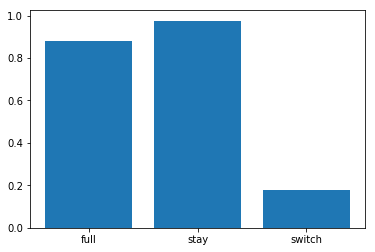

In [15]:
height = [score, accuracy_stay, accuracy_switch]
conditions = ['full', 'stay', 'switch']
plt.bar(range(len(height)), height)
plt.xticks(range(len(height)), conditions)